In [1]:
from itertools import product
from functools import partial
from collections import namedtuple

import glob, sys, os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pipelining, utils
from sklearn.compose import ColumnTransformer

from sklearn.datasets import make_regression, make_classification

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

# Misc
from sklearn.inspection import permutation_importance

# Regression
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoLars, LassoLarsCV
from sklearn.metrics import mean_squared_error, r2_score

# Classification
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import auc, confusion_matrix, f1_score, roc_curve

# Hyperparameter turning
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

def show_nans(df: pd.DataFrame):
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()

def show(df: pd.DataFrame, all_rows=False, all_cols=True):
	args = []
	if all_rows: args.extend(['display.max_rows', None])
	if all_cols: args.extend(['display.max_columns', None])
	with pd.option_context(*args):
		display(df)

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    if 'random' in sys.modules and 'random' in globals():
        print("Setting random seed")
        random.seed(seed)
    
    if 'numpy' in sys.modules and 'np' in globals():
        print("Setting numpy seed")
        np.random.seed(seed)
        
    if 'torch' in sys.modules and 'torch' in globals():
        print("Setting pytorch seed")
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        
seed_everything()

class GridPlotter:
    def __init__(self, r, c, width, height, dir='horizontal'):
        if r<=0 or c<=0:
            raise ValueError(f"Invalid row and column values ({r},{c})")
        
        self.rows = r
        self.cols = c
        self.cur_ind = 0
        
        self.size = (width, height)
        
        if (r==1) and (c==1):
            self.dims = 0
        elif (r==1) or (c==1):
            self.dims = 1
            self.dir = "horizontal" if r==1 else "vertical"
        else:
            self.dims = 2
            if dir != 'horizontal' and dir != 'vertical':
                raise ValueError(f"Invalid direction {dir}")
            self.dir = dir
        
        self.started = False

    def get_ind(self, ind):
        if isinstance(ind, tuple):
            if (ind[0] not in range(self.rows)) or (ind[1] not in range(self.cols)):
                raise ValueError(f"Invalid index {ind=}")
            return ind
        
        if not isinstance(ind, int):
            raise ValueError(f"Invalid index type {type(ind)}")
        
        if ind not in range(self.rows*self.cols):
            raise ValueError(f"Invalid index value of {ind}")
        
        return (self.get_row(ind), self.get_col(ind))
        
    def get_row(self, ind = None):
        if ind == None:
            ind = self.cur_ind

        if self.dims == 0:
            return 0
        else:
            if self.dir == 'horizontal':
                return ind//self.cols
            elif self.dir == 'vertical':
                return ind%self.rows
        
    def get_col(self, ind = None):
        if ind == None:
            ind = self.cur_ind
        if self.dims == 0:
            return 0
        else:
            if self.dir == 'horizontal':
                return ind%self.cols
            elif self.dir == 'vertical':
                return ind//self.rows
    
    def start(self):
        if not self.started:
            self.fig, self.axs = plt.subplots(self.rows, self.cols, figsize=(self.size))
            
            if self.dims == 0:
                self.axs = [[self.axs]]
            elif self.dims == 1:
                if self.dir == 'horizontal':
                    self.axs = self.axs.reshape(1, self.cols)
                elif self.dir =='vertical':
                    self.axs = self.axs.reshape(self.rows, 1)
                    
            self.started = True
                
    def show():
        plt.show()
        
    def get_ax(self, ind = None):
        if ind == None:
            ind = self.cur_ind
        self.start()
        return self.axs[self.get_ind(ind)]
        
    def __iter__(self):
        self.start()
        self.cur_ind = 0
        return self
        
    def __next__(self):
        if self.cur_ind < self.rows*self.cols:
            ind = self.get_ind(self.cur_ind)
            self.cur_ind = self.cur_ind + 1
            return self.axs[ind]
        else:
            raise StopIteration

Setting numpy seed


In [2]:
df = pd.read_csv("output.csv")

In [3]:
show(df)

,energyDeposit,x,y,z,eventID,eventCreatedPhotons
0,0.000010,1800,-5742.21,-5980.17,25,1
1,0.000010,1800,-2368.21,28014.10,66,1
2,0.000010,1800,2697.64,27150.00,82,1
3,0.000009,1800,-1938.52,23051.20,124,1
4,0.000010,1800,4189.04,-25220.50,126,1
...,...,...,...,...,...,...
1881,0.000010,1800,-1518.56,6755.89,9995,10
1882,0.000010,1800,-1430.39,6396.27,9995,10
1883,0.000009,1800,-1501.72,7021.19,9995,10
1884,0.000010,1800,-1666.80,6813.52,9995,10


In [8]:
gb = df.groupby("eventID")

event_num_photons = gb.first()[['eventCreatedPhotons']].reset_index()
event_num_received = gb.count()[['x']].reset_index()

In [22]:
results = pd.merge(left=event_num_photons, right=event_num_received, on="eventID")
results.columns = ['eventID', 'eventCreatedPhotons', 'receivedPhotons']
show(results)

for created_photons in results.eventCreatedPhotons.unique():
    nums = 1000 - len(results[results.eventCreatedPhotons == created_photons])
    print(f"{created_photons=}")
    print(len(results[results.eventCreatedPhotons == created_photons])/1000)
    new_df = pd.DataFrame(data={'eventID': [-1] * nums, 'eventCreatedPhotons': [created_photons] * nums, 'receivedPhotons': [0]*nums})
    results = pd.concat([results, new_df], axis=0)

,eventID,eventCreatedPhotons,receivedPhotons
0,25,1,1
1,66,1,1
2,82,1,1
3,124,1,1
4,126,1,1
...,...,...,...
1181,9982,10,1
1182,9986,10,1
1183,9989,10,1
1184,9995,10,4


created_photons=1
0.037
created_photons=2
0.073
created_photons=3
0.09
created_photons=4
0.109
created_photons=5
0.115
created_photons=6
0.12
created_photons=7
0.137
created_photons=8
0.155
created_photons=9
0.173
created_photons=10
0.177


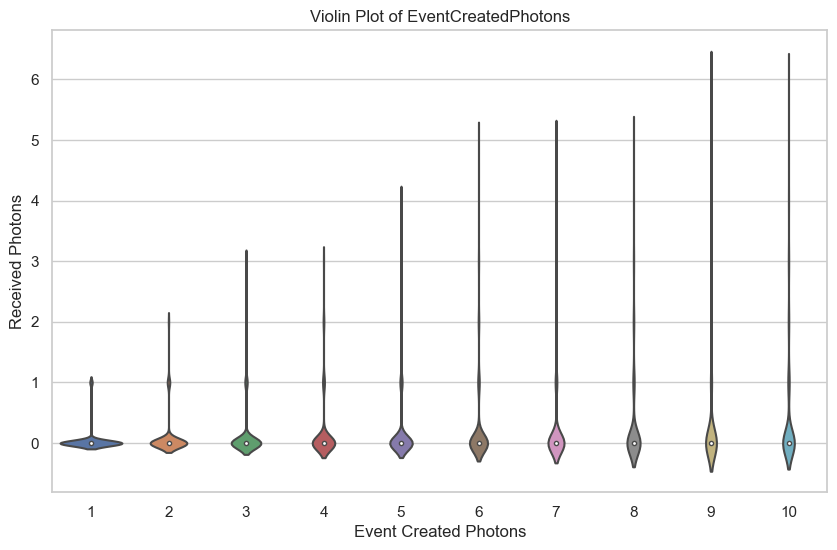

In [19]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x="eventCreatedPhotons", y="receivedPhotons", data=results, ax=ax)

# Customize the plot
ax.set_title("Violin Plot of EventCreatedPhotons")
ax.set_xlabel("Event Created Photons")
ax.set_ylabel("Received Photons")

# Show the plot
plt.show()